In [16]:
import numpy as np
import ot
import cvxpy as cp
import matplotlib.pyplot as plt
import cv2
from utils.Visualizations import *

# 1D tests for unbalanced

## Normal

In [89]:
n_p = 100
n_q = 100
X,Y = np.linspace(0,1,n_p), np.linspace(0,1,n_q)

p = make_1D_gauss(n_p, np.floor(1 * n_p / 4.), 2.) + make_1D_gauss(n_p, np.floor(2 * n_p / 4.), 2.) * (-0.5)
q = make_1D_gauss(n_q, np.floor(5 * n_q / 8.), 2.) + make_1D_gauss(n_q, np.floor(7 * n_q / 8.), 2.) * (-0.5)

C = np.zeros([n_p,n_q],dtype=np.float64)

dist_f1 = lambda a,b : abs(a-b)
dist_f2 = lambda a,b : (a-b)**2
for it1 in range(n_p):
    for it2 in range(n_q):
        C[it1,it2] = dist_f2(X[it1],Y[it2])

In [18]:
## To work with the signed measures
p_pos, p_neg = split_signed_measure(p)
q_pos, q_neg = split_signed_measure(q)

<Figure size 600x600 with 0 Axes>

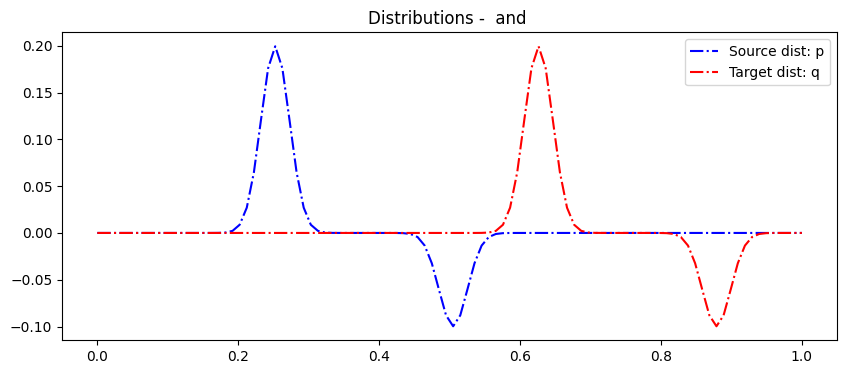

In [24]:
plt.figure(figsize=(6,6))
plot_marginals(X,p,q,'Distributions -  and ')

In [25]:
new_p = p_pos + q_neg
new_q = p_neg + q_pos

<Figure size 600x600 with 0 Axes>

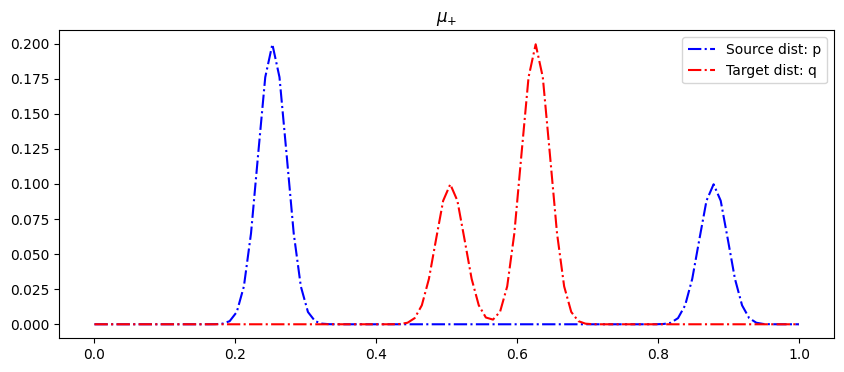

In [26]:
plt.figure(figsize=(6,6))
plot_marginals(X, new_p, new_q, '$\mu_{+}$')

In [27]:
transport_plan, transport_cost = calc_transport_pot_emd(new_p, new_q, C)

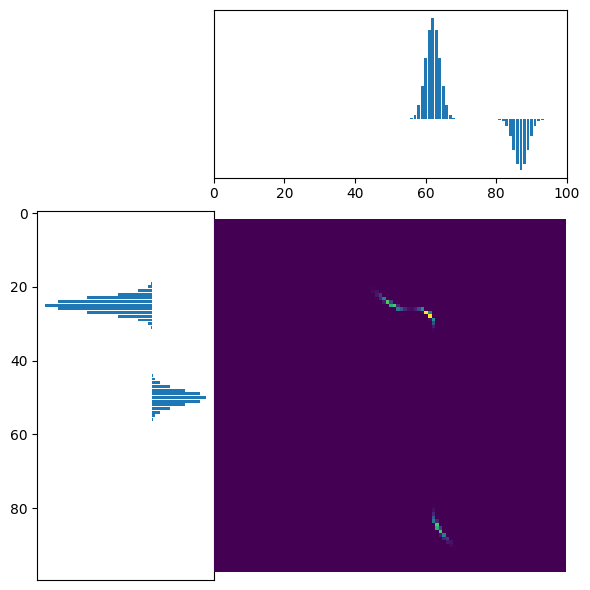

In [28]:
plt.figure(figsize=(6,6))
plot1D_mat_bar(p.flatten(), q.flatten(), transport_plan, '')

## Noised measures

In [99]:
p = make_1D_gauss(n_p, np.floor(1 * n_p / 4.), 2.) + make_1D_gauss(n_p, np.floor(2 * n_p / 4.), 2.) * (-0.5)
q = make_1D_gauss(n_q, np.floor(5 * n_q / 8.), 2.) + make_1D_gauss(n_q, np.floor(7 * n_q / 8.), 2.) * (-0.5)

In [100]:
p_noised = noise_image(p, noise_param=1e-2)
q_noised = noise_image(q, noise_param=1e-2)

<Figure size 600x600 with 0 Axes>

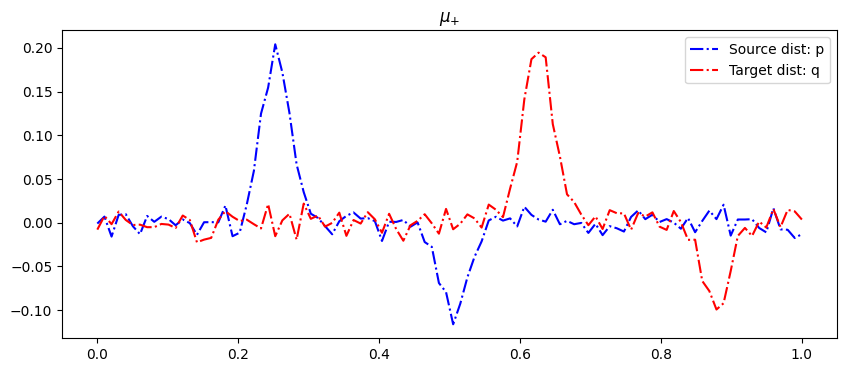

In [102]:
plt.figure(figsize=(6,6))
plot_marginals(X, p_noised, q_noised, '$\mu_{+}$')

In [103]:
p_noised_pos, p_noised_neg = split_signed_measure(p_noised)
q_noised_pos, q_noised_neg = split_signed_measure(q_noised)

p_noised_new = p_noised_pos + q_noised_neg
q_noised_new = p_noised_neg + q_noised_pos

<Figure size 600x600 with 0 Axes>

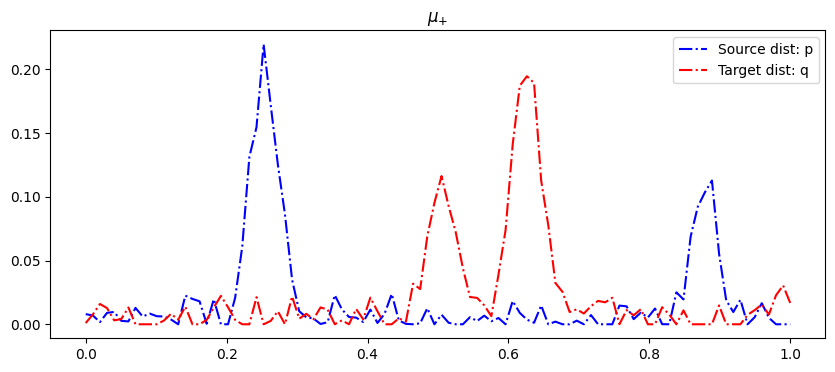

In [104]:
plt.figure(figsize=(6,6))
plot_marginals(X, p_noised_new, q_noised_new, '$\mu_{+}$')

In [105]:
plan_noised_new = ot.unbalanced.mm_unbalanced(a = p_noised_new.flatten(), b = q_noised_new.flatten(), M = C, reg_m = 1)

In [106]:
plan_noised_new.shape

(100, 100)

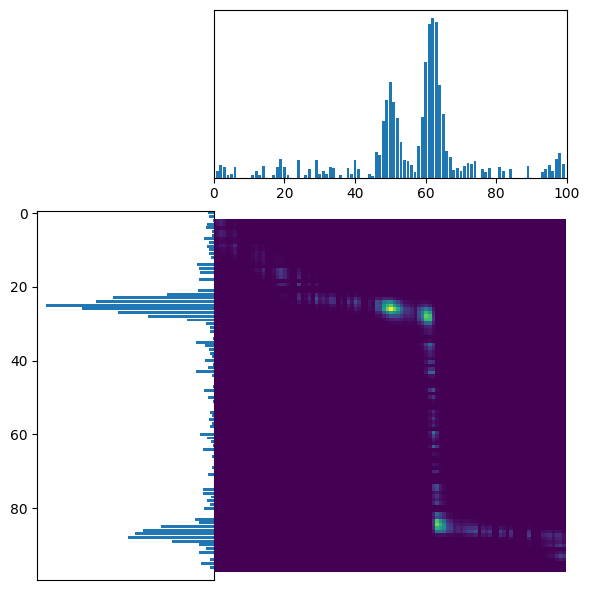

In [107]:
plt.figure(figsize=(6,6))
plot1D_mat_bar(p_noised_new.flatten(), q_noised_new.flatten(), plan_noised_new, '')

# Images

In [2]:
im1 = np.zeros([5,5])
im1[0,0] = 1
im2 = np.zeros([5,5])
im2[2,3] = 1

In [31]:
def noise_image(im, noise_param = 1e-2):
    """takes an image and makes it noisy"""
    noisy_image = im
    height, width = im.shape
    for i in range(height):
        for j in range(width):
            noisy_image[i,j] += np.random.normal(0, noise_param)

    return noisy_image

In [4]:
im1_norm = im1/im1.sum()
im2_norm = im2/im2.sum()

im1_noisy = noise_image(im1_norm, 5e-2)
im2_noisy = noise_image(im2_norm, 5e-2)

In [7]:
def calculate_costs(size):
    """
    This function of an array or image and calculates the cost from it to itself.

    Parameters:
    - `size` (int or 2d array): representing the object on which we would like to calculate costs.

    Returns:
    - `costs` (numpy.ndarray): A 2D array representing the matrix of costs of transporting pixels
                                from the first image to the second image.
    """
    # TODO: Make this more efficient
    # 1D case:
    if type(size) == int:
        costs = np.zeros([size, size])
        m,n = int(np.sqrt(size)), int(np.sqrt(size))
        for i in range(m):
            for j in range(n):
                for k in range(m):
                    for l in range(n):
                        location_x = (i * n) + j
                        location_y = (k * n) + l
                        costs[location_x, location_y] += np.sqrt((i - k) ** 2 + (j - l) ** 2)
        return costs
    elif len(size) == 2:
        size_1d = size[0] * size[1]
        costs = np.zeros([size_1d, size_1d])
        m, n = size[0], size[1]
        for i in range(m):
            for j in range(n ):
                for k in range(m):
                    for l in range(n):
                        location_x = (i * n) + j
                        location_y = (k * n) + l
                        costs[location_x, location_y] += np.sqrt((i - k) ** 2 + (j - l) ** 2)
        return costs

In [8]:
def split_signed_measure(source: np.ndarray) -> (np.ndarray, np.ndarray):
    source_pos: np.ndarray = np.zeros(source.shape)
    source_neg: np.ndarray = np.zeros(source.shape)

    source_pos[source > 0] = source[source > 0]
    source_neg[source < 0] = -source[source < 0]

    return source_pos, source_neg

In [9]:
## To work with the signed measures
im1_pos, im1_neg = split_signed_measure(im1_noisy.flatten())
im2_pos, im2_neg = split_signed_measure(im2_noisy.flatten())

im1_new = (im1_pos + im2_neg).reshape(im1.shape)
im2_new = (im1_neg + im2_pos).reshape(im2.shape)

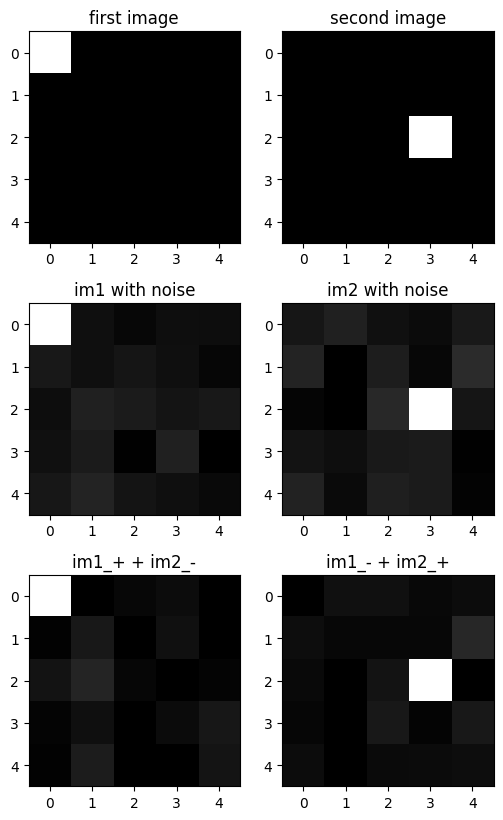

In [10]:
fig = plt.figure(figsize=(6, 10))

fig.add_subplot(3, 2, 1)
plt.title('first image')
plt.imshow(im1, cmap='gray')

fig.add_subplot(3, 2, 2)
plt.title('second image')
plt.imshow(im2, cmap='gray')

fig.add_subplot(3, 2, 3)
plt.title('im1 with noise')
plt.imshow(im1_noisy, cmap='gray')

fig.add_subplot(3, 2, 4)
plt.title('im2 with noise')
plt.imshow(im2_noisy, cmap='gray')

fig.add_subplot(3, 2, 5)
plt.title('im1_+ + im2_-')
plt.imshow(im1_new, cmap='gray')

fig.add_subplot(3, 2, 6)
plt.title('im1_- + im2_+')
plt.imshow(im2_new, cmap='gray')

In [12]:
C = calculate_costs(im1.shape)

In [13]:
plan = ot.unbalanced.mm_unbalanced(a = im1_new.flatten(), b = im2_new.flatten(), M = C, reg_m = 1)